<a href="https://colab.research.google.com/github/sauravdas093/Kaggle_Challenge/blob/main/2)Classification_Metrics_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pixeltests School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions



The tasks for this project are as follows:
- **Task 0:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

In [ ]:
import pandas as pd
import numpy as np
def preprocess(df):
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/demo/train_features.csv',na_values=[0, -2.000000e-08])
labels = pd.read_csv('/content/drive/MyDrive/demo/train_labels.csv',na_values=[0, -2.000000e-08])
df['status_group']=labels['status_group'].values
X_test = pd.read_csv('/content/drive/MyDrive/demo/test_features.csv',na_values=[0, -2.000000e-08])

In [ ]:
df = preprocess(df)
X_test = preprocess(X_test)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
X = df.drop('status_group',axis=1)
y = labels

In [ ]:
y = y['status_group']

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, train_size=0.80, test_size=0.20,
                              stratify=df['status_group'], random_state=42)

In [ ]:
X_train = train.drop('status_group',axis=1)
y_train = train['status_group']

In [ ]:
X_val = val.drop('status_group',axis=1)
y_val = val['status_group']

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred= [majority_class] * len(y_train)
baseline_acc = accuracy_score(y_train, y_pred)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430871212121212


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [ ]:
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    # FunctionTransformer(wrangle,validate=False),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [ ]:
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    2
communal standpipe             3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:
y_pred = model.predict(X_val)

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [ ]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9999736952861953
Validation Accuracy Score: 0.79871632996633


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

[[4546  140  475]
 [ 346  225  120]
 [ 779   53 2820]]


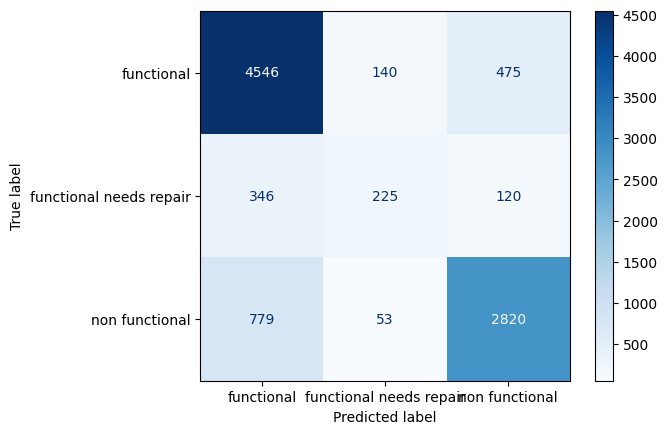

In [ ]:
# Plot 3x3 confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_val,
        y_val,
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        # normalize=normalize,
    )

print(disp.confusion_matrix)
plt.show()

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [ ]:
# Print classification report
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.88      0.84      5161
functional needs repair       0.54      0.33      0.41       691
         non functional       0.83      0.77      0.80      3652

               accuracy                           0.80      9504
              macro avg       0.72      0.66      0.68      9504
           weighted avg       0.79      0.80      0.79      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?


**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
model.predict_proba(X_test)

array([[0.6 , 0.05, 0.35],
       [0.83, 0.08, 0.09],
       [0.87, 0.02, 0.11],
       ...,
       [0.37, 0.02, 0.61],
       [0.61, 0.02, 0.37],
       [1.  , 0.  , 0.  ]])

In [ ]:
threshold = 0.95
y_pred_proba = model.predict_proba(X_val)[:,2]>threshold
results = pd.DataFrame ({'y_val':y_val,'y_pred_proba':y_pred_proba})

In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:,2]>threshold

X_test_nf = pd.DataFrame ({'y_pred_proba':y_pred_proba_test})
X_test_nf

,y_pred_proba
0,False
1,False
2,False
3,False
4,False
...,...
11875,False
11876,False
11877,False
11878,False


In [ ]:
X_test_nf['y_pred_proba'].value_counts()

False    10257
True      1623
Name: y_pred_proba, dtype: int64

In [ ]:
X_test_nf = X_test_nf[(X_test_nf==True).any(axis=1)]

In [ ]:
X_test_nf['population'] = df['population']
# X_test_nf = X_test_nf.join(df['population'])

<ipython-input-25-6b1f3f6649f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_nf['population'] = df['population']


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
X_test_nf = X_test_nf.sort_values(by='population', ascending=False)[0:100]

In [ ]:
X_test_nf

,y_pred_proba,population
4873,True,6922.0
7512,True,5560.0
10583,True,5400.0
2679,True,4100.0
5383,True,4000.0
...,...,...
1124,True,629.0
5758,True,620.0
5426,True,610.0
11364,True,610.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [ ]:
X_test_nf_100_loc = X_test_nf.join(df['longitude'])
X_test_nf_100_loc = X_test_nf_100_loc.join(df['latitude'])
X_test_nf_100_loc

,y_pred_proba,population,longitude,latitude
4873,True,6922.0,39.287767,-6.974183
7512,True,5560.0,31.626783,-7.980337
10583,True,5400.0,38.996737,-7.359257
2679,True,4100.0,31.001899,-8.255645
5383,True,4000.0,34.713071,-1.746166
...,...,...,...,...
1124,True,629.0,39.356343,-10.857845
5758,True,620.0,37.281767,-3.457090
5426,True,610.0,33.032210,-2.018939
11364,True,610.0,34.283099,-1.691258


In [ ]:
import plotly.express as px
px.scatter(X_test_nf_100_loc,x='longitude',y='latitude',color='y_pred_proba',opacity=1)